In [1]:
! python --version

Python 3.10.11


In [2]:
! pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from typing import Optional

import abc
import numpy as np
import math
import pandas as pd

from sklearn.preprocessing import LabelEncoder

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data_path = 'drive/MyDrive/mts_lib_copy/'
# data_path = 'data/'
log_name = 'interactions.csv'
u_features_name = 'users.csv'
i_features_name = 'items.csv'

In [6]:
SEED = 123
K=10

# [Self-Attentive Sequential Recommendation (SASRec)](https://arxiv.org/pdf/1808.09781.pdf)

![](https://habrastorage.org/webt/dw/_e/py/dw_epy6vieqz8ly3adrr2i5-spa.png)

![](https://habrastorage.org/webt/rc/cy/gn/rccygnt8_n2tk6ss2fpjq_r0njk.png)

### Turning Dross Into Gold Loss: is BERT4Rec really better than SASRec?: Sber Ai Lab, 2023

Recently sequential recommendations and next-item prediction task has become increasingly popular in the field of recommender
systems. Currently, two state-of-the-art baselines are Transformer-based models SASRec and BERT4Rec. Over the past few years,
there have been quite a few publications comparing these two algorithms and proposing new state-of-the-art models. In most of the
publications, BERT4Rec achieves better performance than SASRec. But BERT4Rec uses cross-entropy over softmax for all items, while
SASRec uses negative sampling and calculates binary cross-entropy loss for one positive and one negative item. In our work, we show
that if both models are trained with the same loss which is used by BERT4Rec, then SASRec will significantly outperform BERT4Rec
both in terms of quality and training speed. In addition, we show that SASRec could be effectively trained with negative sampling and
still outperform BERT4Rec, but the number of negative examples should be much larger than one.

# Датасет

Будем использовать датасет [MTS Library](https://www.kaggle.com/sharthz23/mts-library), содержащий данные об истории чтения книг пользователями МТС Библиотеки.

### Предобработка

In [7]:
df = pd.read_csv(data_path+log_name, sep=',')

In [8]:
assert df.shape[0] == 1533078

In [9]:
df.head(2)

,user_id,item_id,progress,rating,start_date
0,126706,14433,80,NaN,2018-01-01
1,127290,140952,58,NaN,2018-01-01


In [10]:
%%time
# конвертируем в дату
df.loc[:, 'start_date'] = pd.to_datetime(df['start_date'], format="%Y-%m-%d")
# удаляем дубликаты, оставляя последний по времени
df = df.sort_values('start_date').drop_duplicates(subset=['user_id', 'item_id'], keep='last')

u_features = pd.read_csv(data_path+u_features_name, sep=',')
i_features = pd.read_csv(data_path+i_features_name, sep=',')
i_features.rename(columns={'id': 'item_id'}, inplace=True)

<timed exec>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


CPU times: user 683 ms, sys: 92.1 ms, total: 776 ms
Wall time: 954 ms


### Данные

In [11]:
u_features.head(2)

,user_id,age,sex
0,1,45_54,NaN
1,2,18_24,0.0


In [12]:
%%time
i_features.head(2)

CPU times: user 0 ns, sys: 108 µs, total: 108 µs
Wall time: 112 µs


,item_id,title,genres,authors,year
0,128115,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
1,210979,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894


In [13]:
i_features.shape, i_features['item_id'].isin(df['item_id'].unique()).shape

((59599, 5), (59599,))

In [14]:
def get_log_info(log, user_id='user_id', item_id='item_id'):
    print(f'Длина лога = {log.shape[0]},\nколичество пользователей = {log[user_id].nunique()},\nколичество объектов = {log[item_id].nunique()}')

In [15]:
get_log_info(df)

Длина лога = 1532998,
количество пользователей = 151600,
количество объектов = 59599


In [16]:
f"Количество рейтингов = {(~df['rating'].isna()).sum()}, что сильно меньше, чем количество данных о прогрессе чтения ({(~df['progress'].isna()).sum()})"


'Количество рейтингов = 285337, что сильно меньше, чем количество данных о прогрессе чтения (1532998)'

In [17]:
df.head(2)

,user_id,item_id,progress,rating,start_date
0,126706,14433,80,NaN,2018-01-01
1437,97128,245669,1,NaN,2018-01-01


<a id='filter'></a>
# 0 Фильтрация данных

### Оставим взаимодействия с progress > 50

In [18]:
filtered_df = df[df['progress'] > 50]

In [19]:
get_log_info(filtered_df)

Длина лога = 712368,
количество пользователей = 143465,
количество объектов = 59560


### Удалим объекты и пользователей менее чем с 5 взаимодействиями

In [20]:
item_counts = filtered_df.groupby('item_id')['user_id'].count()
pop_items = item_counts[item_counts > 4]
filtered_df = filtered_df[filtered_df['item_id'].isin(pop_items.index)]

In [21]:
user_counts = filtered_df.groupby('user_id')['item_id'].count()
pop_users = user_counts[user_counts > 4]
filtered_df = filtered_df[filtered_df['user_id'].isin(pop_users.index)].copy()

In [22]:
get_log_info(filtered_df)

Длина лога = 423599,
количество пользователей = 33875,
количество объектов = 50982


In [23]:
assert filtered_df.shape[0] == 423599
assert filtered_df['user_id'].nunique() == 33875

### Конвертация id

In [24]:
%%time
# конвертируем id пользователей и item-ов в подряд идущие номера
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
user_encoder.fit(filtered_df['user_id'])
item_encoder.fit(filtered_df['item_id'])

CPU times: user 69.2 ms, sys: 0 ns, total: 69.2 ms
Wall time: 70.1 ms


LabelEncoder()

In [25]:
user_encoder.transform(np.array([21]))

array([4])

In [26]:
i_features_filtered = i_features[i_features['item_id'].isin(filtered_df['item_id'].unique())].copy()
u_features_filtered = u_features[u_features['user_id'].isin(filtered_df['user_id'].unique())].copy()

In [27]:
%%time
filtered_df.loc[:, 'user_id'] = user_encoder.transform(filtered_df['user_id'])
filtered_df.loc[:, 'item_id'] = item_encoder.transform(filtered_df['item_id'])

CPU times: user 195 ms, sys: 32 µs, total: 195 ms
Wall time: 200 ms


In [28]:
%%time
i_features_filtered.loc[:, 'item_id'] = item_encoder.transform(i_features_filtered['item_id'])
u_features_filtered.loc[:, 'user_id'] = user_encoder.transform(u_features_filtered['user_id'])
# i_features_filtered.set_index('item_id', inplace=True)

CPU times: user 16.4 ms, sys: 67 µs, total: 16.4 ms
Wall time: 18.5 ms


# 1 Разбиение данных


Стандартный подход для валидации sequential models в рекомендательных системах - отложить последнее взаимодействия пользователя в test, а предпоследнее - в валидацию.

![split](https://habrastorage.org/webt/b9/wy/tt/b9wyttarflehtevud3pw4puvkh4.png)

In [29]:
filtered_df = filtered_df.drop(columns=['rating', 'progress'])

Добавим номер в последовательности time_idx - от первого взаимодействия, time_idx_reversed - от последнего взаимодействия

In [30]:
def add_time_idx(df, user_col='user_id', timestamp_col='timestamp', sort=True):
    """Add time index to interactions dataframe."""

    if sort:
        df = df.sort_values([user_col, timestamp_col])

    df['time_idx'] = df.groupby(user_col).cumcount()
    df['time_idx_reversed'] = df.groupby(user_col).cumcount(ascending=False)

    return df

In [31]:
data = add_time_idx(filtered_df, timestamp_col='start_date', sort=False)

train = data[data.time_idx_reversed >= 2]
validation_full = data[data.time_idx_reversed >= 1]
test = data[data.time_idx_reversed == 0]
item_count = data.item_id.max()

In [32]:
get_log_info(train)

Длина лога = 355849,
количество пользователей = 33875,
количество объектов = 48862


In [33]:
get_log_info(validation_full)

Длина лога = 389724,
количество пользователей = 33875,
количество объектов = 50118


In [34]:
get_log_info(test)

Длина лога = 33875,
количество пользователей = 33875,
количество объектов = 22621


In [35]:
train.sort_values(['user_id', 'start_date']).head(10)

,user_id,item_id,start_date,time_idx,time_idx_reversed
376972,0,48279,2018-07-02,0,4
381660,0,32505,2018-07-04,1,3
405973,0,24070,2018-07-15,2,2
128625,1,41529,2018-03-03,0,5
147844,1,22451,2018-03-12,1,4
914012,1,9719,2019-03-13,2,3
1121061,1,11965,2019-06-18,3,2
31979,2,36469,2018-01-16,0,10
937058,2,42823,2019-03-24,1,9
1065853,2,36708,2019-05-23,2,8


# 2 Dataset/Dataloader

In [36]:
import numpy as np
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

In [37]:
MAX_LENGTH = 128

VALIDATION_SIZE = 5000
# VALIDATION_SIZE = None

BATCH_SIZE = 64
TEST_BATCH_SIZE = 32
NUM_WORKERS = 8

NUM_NEGATIVES = 200

In [38]:
class LMDataset(Dataset):

    def __init__(self, df, max_length=128, num_negatives=None,
                 user_col='user_id', item_col='item_id', time_col='time_idx'):

        self.max_length = max_length
        self.num_negatives = num_negatives
        self.user_col = user_col
        self.item_col = item_col
        self.time_col = time_col

        self.data = df.sort_values(time_col).groupby(user_col)[item_col].agg(list).to_dict()
        self.user_ids = list(self.data.keys())

        if num_negatives:
            self.all_items = df[item_col].unique()

    def __len__(self):
        return len(self.data)

    def sample_negatives(self, item_sequence):
        negatives = self.all_items[~np.isin(self.all_items, item_sequence)]
        negatives = np.random.choice(
            negatives, size=self.num_negatives * (len(item_sequence) - 1), replace=True)
        negatives = negatives.reshape(len(item_sequence) - 1, self.num_negatives)
        return negatives


class CausalLMDataset(LMDataset):

    def __init__(self, df, max_length=128, num_negatives=None,
                 user_col='user_id', item_col='item_id', time_col='time_idx'):

        super().__init__(df, max_length, num_negatives,
                         user_col, item_col, time_col)

    def __getitem__(self, idx):

        item_sequence = self.data[self.user_ids[idx]]

        if len(item_sequence) > self.max_length + 1:
            item_sequence = item_sequence[-self.max_length - 1:]

        input_ids = np.array(item_sequence[:-1])
        labels = np.array(item_sequence[1:])

        if self.num_negatives:
            negatives = self.sample_negatives(item_sequence)
            return {'input_ids': input_ids, 'labels': labels, 'negatives': negatives}

        return {'input_ids': input_ids, 'labels': labels}


class CausalLMPredictionDataset(LMDataset):
    def __init__(self, df, max_length=128, validation_mode=False,
                 user_col='user_id', item_col='item_id',
                 time_col='time_idx'):

        super().__init__(df, max_length=max_length, num_negatives=None,
                         user_col=user_col, item_col=item_col, time_col=time_col)

        self.validation_mode = validation_mode

    def __getitem__(self, idx):

        user_id = self.user_ids[idx]
        item_sequence = self.data[user_id]

        if self.validation_mode:
            target = item_sequence[-1]
            input_ids = item_sequence[-self.max_length-1:-1]
            item_sequence = item_sequence[:-1]

            return {'input_ids': input_ids, 'user_id': user_id,
                    'full_history': item_sequence, 'target': target}
        else:
            input_ids = item_sequence[-self.max_length:]

            return {'input_ids': input_ids, 'user_id': user_id,
                    'full_history': item_sequence}


In [39]:
class PaddingCollateFn:

    def __init__(self, padding_value=0, labels_padding_value=-100):

        self.padding_value = padding_value
        self.labels_padding_value = labels_padding_value

    def __call__(self, batch):

        collated_batch = {}

        for key in batch[0].keys():

            if np.isscalar(batch[0][key]):
                collated_batch[key] = torch.tensor([example[key] for example in batch])
                continue

            if key == 'labels':
                # -100 to ignore index in nn.CrossEntropyLoss
                padding_value = self.labels_padding_value
            else:
                padding_value = self.padding_value
            values = [torch.tensor(example[key]) for example in batch]
            collated_batch[key] = pad_sequence(values, batch_first=True,
                                               padding_value=padding_value)

        if 'input_ids' in collated_batch:
            attention_mask = collated_batch['input_ids'] != self.padding_value
            collated_batch['attention_mask'] = attention_mask.to(dtype=torch.float32)  

        return collated_batch


In [40]:
validation_users = validation_full.user_id.unique()
if VALIDATION_SIZE:
    validation_users = np.random.choice(validation_users, size=VALIDATION_SIZE, replace=False)
eval_dataset = CausalLMPredictionDataset(validation_full[validation_full.user_id.isin(validation_users)],
                                         max_length=MAX_LENGTH, validation_mode=True)


train_dataset = CausalLMDataset(train, max_length=MAX_LENGTH,  num_negatives=NUM_NEGATIVES)

In [41]:
collate_fn = PaddingCollateFn()

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORKERS,
    collate_fn=PaddingCollateFn())
eval_loader = DataLoader(
    eval_dataset, batch_size=TEST_BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS,
    collate_fn=PaddingCollateFn())

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [42]:
batch = next(iter(train_loader))
print(batch['input_ids'].shape)

torch.Size([64, 128])


In [43]:
batch

{'input_ids': tensor([[ 8116, 32392,  1395,  ...,     0,     0,     0],
         [26135,  7182, 39989,  ...,     0,     0,     0],
         [33771, 34959,     0,  ...,     0,     0,     0],
         ...,
         [39284, 17350, 26828,  ...,     0,     0,     0],
         [14658, 32408,     0,  ...,     0,     0,     0],
         [33233, 24564, 39323,  ...,     0,     0,     0]]),
 'labels': tensor([[32392,  1395, 26082,  ...,  -100,  -100,  -100],
         [ 7182, 39989, 47484,  ...,  -100,  -100,  -100],
         [34959, 21357,  -100,  ...,  -100,  -100,  -100],
         ...,
         [17350, 26828, 38274,  ...,  -100,  -100,  -100],
         [32408,  3350,  -100,  ...,  -100,  -100,  -100],
         [24564, 39323, 29207,  ...,  -100,  -100,  -100]]),
 'negatives': tensor([[[18336,  8389, 44539,  ..., 22652, 19016, 11030],
          [21122, 44249, 15411,  ...,  5432,  6509,  6376],
          [28285,  3913,  4713,  ..., 12218, 35722, 19702],
          ...,
          [    0,     0,     

# 3 Model

N is a batch size, 
C denotes a number of channels, 
L is a length of signal sequence.

- Batch: (N, L, C)
- Output with head: (N, L, num_items)
- Output without head: (N, L, C)

In [44]:
class PointWiseFeedForward(nn.Module):

    def __init__(self, hidden_units, dropout_rate):

        super(PointWiseFeedForward, self).__init__()

        self.conv1 = nn.Conv1d(hidden_units, hidden_units, kernel_size=1)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(hidden_units, hidden_units, kernel_size=1)
        self.dropout2 = nn.Dropout(p=dropout_rate)

    def forward(self, inputs):
        outputs = self.dropout2(
            self.conv2(self.relu(self.dropout1(self.conv1(inputs.transpose(-1, -2))))))
        outputs = outputs.transpose(-1, -2) # as Conv1D requires (N, C, Length)
        outputs += inputs
        return outputs



class SASRec(nn.Module):
    """Adaptation of code from
    https://github.com/pmixer/SASRec.pytorch.
    """

    def __init__(self, item_num, maxlen=128, hidden_units=64, num_blocks=1,
                 num_heads=1, dropout_rate=0.1, initializer_range=0.02,
                 add_head=True):

        super(SASRec, self).__init__()

        self.item_num = item_num
        self.maxlen = maxlen
        self.hidden_units = hidden_units
        self.num_blocks = num_blocks
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.initializer_range = initializer_range
        self.add_head = add_head

        self.item_emb = nn.Embedding(item_num + 1, hidden_units, padding_idx=0)
        self.pos_emb = nn.Embedding(maxlen, hidden_units)
        self.emb_dropout = nn.Dropout(dropout_rate)

        self.attention_layernorms = nn.ModuleList()
        self.attention_layers = nn.ModuleList()
        self.forward_layernorms = nn.ModuleList()
        self.forward_layers = nn.ModuleList()

        self.last_layernorm = nn.LayerNorm(hidden_units, eps=1e-8)

        for _ in range(num_blocks):
            new_attn_layernorm = nn.LayerNorm(hidden_units, eps=1e-8)
            self.attention_layernorms.append(new_attn_layernorm)

            new_attn_layer = nn.MultiheadAttention(hidden_units,
                                                   num_heads,
                                                   dropout_rate)
            self.attention_layers.append(new_attn_layer)

            new_fwd_layernorm = nn.LayerNorm(hidden_units, eps=1e-8)
            self.forward_layernorms.append(new_fwd_layernorm)

            new_fwd_layer = PointWiseFeedForward(hidden_units, dropout_rate)
            self.forward_layers.append(new_fwd_layer)

        # parameters initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """Initialize weights.

        Examples:
        https://github.com/huggingface/transformers/blob/v4.25.1/src/transformers/models/gpt2/modeling_gpt2.py#L454
        https://recbole.io/docs/_modules/recbole/model/sequential_recommender/sasrec.html#SASRec
        """

        if isinstance(module, (nn.Linear, nn.Conv1d)):
            module.weight.data.normal_(mean=0.0, std=self.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    # parameter attention mask added for compatibility with Lightning module, not used
    def forward(self, input_ids, attention_mask):
        seqs = self.item_emb(input_ids.long())
        seqs *= self.item_emb.embedding_dim ** 0.5
        positions = np.tile(np.array(range(input_ids.shape[1])), [input_ids.shape[0], 1])
        seqs += self.pos_emb(torch.LongTensor(positions).to(seqs.device))
        seqs = self.emb_dropout(seqs)

        # zero out padded sequence elements 
        timeline_mask = torch.Tensor(input_ids == 0)
        seqs *= ~timeline_mask.unsqueeze(-1) # broadcast in last dim
        # to avoid leak
        tl = seqs.shape[1]
        attention_mask = ~torch.tril(torch.ones((tl, tl), dtype=torch.bool).to(seqs.device))

        for i in range(len(self.attention_layers)):
            seqs = torch.transpose(seqs, 0, 1)
            Q = self.attention_layernorms[i](seqs)
            mha_outputs, _ = self.attention_layers[i](Q, seqs, seqs, 
                                            attn_mask=attention_mask)
                                            
            seqs = Q + mha_outputs
            seqs = torch.transpose(seqs, 0, 1)

            seqs = self.forward_layernorms[i](seqs)
            seqs = self.forward_layers[i](seqs)
            seqs *=  ~timeline_mask.unsqueeze(-1)
        outputs = self.last_layernorm(seqs)
        if self.add_head:
            outputs = torch.matmul(outputs, self.item_emb.weight.transpose(0, 1))
        return outputs

In [45]:
SASREC_CONFIG = {
    'maxlen': MAX_LENGTH,
    'hidden_units': 64,
    'num_blocks': 2,
    'num_heads': 1,
    'dropout_rate': 0.1,
}

model = SASRec(item_num=data.item_id.max(), **SASREC_CONFIG)

In [46]:
out = model(batch['input_ids'], batch['attention_mask'])
out.shape

torch.Size([64, 128, 50982])

In [47]:
batch['input_ids'][0]

tensor([ 8116, 32392,  1395, 26082, 29529, 49372, 15718, 33769, 24848,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [48]:
out[0, 3, :]

tensor([ 0.0000, -0.1067,  0.1969,  ..., -0.3041, -0.0350,  0.2180],
       grad_fn=<SliceBackward0>)

In [49]:
TRAINER_PARAMS = {
    'max_epochs': 15,
    'enable_checkpointing': True,
}

# 4 Training

In [50]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, ModelSummary

In [51]:
import numpy as np
import pytorch_lightning as pl
import torch
from torch import nn


class SeqRecBase(pl.LightningModule):

    def __init__(self, model, lr=1e-3, padding_idx=0,
                 predict_top_k=10, filter_seen=True):

        super().__init__()

        self.model = model
        self.lr = lr
        self.padding_idx = padding_idx
        self.predict_top_k = predict_top_k
        self.filter_seen = filter_seen

    def configure_optimizers(self):

        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def predict_step(self, batch, batch_idx):

        preds, scores = self.make_prediction(batch)

        scores = scores.detach().cpu().numpy()
        preds = preds.detach().cpu().numpy()
        user_ids = batch['user_id'].detach().cpu().numpy()

        return {'preds': preds, 'scores': scores, 'user_ids': user_ids}

    def validation_step(self, batch, batch_idx):

        preds, scores = self.make_prediction(batch)
        metrics = self.compute_val_metrics(batch['target'], preds)

        self.log("val_ndcg", metrics['ndcg'], prog_bar=True)
        self.log("val_hit_rate", metrics['hit_rate'], prog_bar=True)
        self.log("val_mrr", metrics['mrr'], prog_bar=True)

    def make_prediction(self, batch):

        outputs = self.prediction_output(batch)

        input_ids = batch['input_ids']
        rows_ids = torch.arange(input_ids.shape[0], dtype=torch.long, device=input_ids.device)
        last_item_idx = (input_ids != self.padding_idx).sum(axis=1) - 1

        preds = outputs[rows_ids, last_item_idx, :]

        scores, preds = torch.sort(preds, descending=True)

        if self.filter_seen:
            seen_items = batch['full_history']
            preds, scores = self.filter_seen_items(preds, scores, seen_items)
        else:
            scores = scores[:, :self.predict_top_k]
            preds = preds[:, :self.predict_top_k]

        return preds, scores

    def filter_seen_items(self, preds, scores, seen_items):

        max_len = seen_items.size(1)
        scores = scores[:, :self.predict_top_k + max_len]
        preds = preds[:, :self.predict_top_k + max_len]

        final_preds, final_scores = [], []
        for i in range(preds.size(0)):
            not_seen_indexes = torch.isin(preds[i], seen_items[i], invert=True)
            pred = preds[i, not_seen_indexes][:self.predict_top_k]
            score = scores[i, not_seen_indexes][:self.predict_top_k]
            final_preds.append(pred)
            final_scores.append(score)

        final_preds = torch.vstack(final_preds)
        final_scores = torch.vstack(final_scores)

        return final_preds, final_scores

    def compute_val_metrics(self, targets, preds):

        ndcg, hit_rate, mrr = 0, 0, 0

        for i, pred in enumerate(preds):
            if torch.isin(targets[i], pred).item():
                hit_rate += 1
                rank = torch.where(pred == targets[i])[0].item() + 1
                ndcg += 1 / np.log2(rank + 1)
                mrr += 1 / rank

        hit_rate = hit_rate / len(targets)
        ndcg = ndcg / len(targets)
        mrr = mrr / len(targets)

        return {'ndcg': ndcg, 'hit_rate': hit_rate, 'mrr': mrr}


class SeqRec(SeqRecBase):

    def training_step(self, batch, batch_idx):

        outputs = self.model(batch['input_ids'], batch['attention_mask'])
        loss = self.compute_loss(outputs, batch)

        return loss

    def compute_loss(self, outputs, batch):

        loss_fct = nn.CrossEntropyLoss()
        if batch['labels'].dtype == torch.float64:
            print(batch)
        loss = loss_fct(outputs.view(-1, outputs.size(-1)), batch['labels'].view(-1))

        return loss

    def prediction_output(self, batch):

        return self.model(batch['input_ids'], batch['attention_mask'])

In [52]:
seqrec_module = SeqRec(model, predict_top_k=10)

early_stopping = EarlyStopping(monitor="val_ndcg", mode="max", patience=5, verbose=False)
model_summary = ModelSummary(max_depth=4)
checkpoint = ModelCheckpoint(save_top_k=1, monitor="val_ndcg", mode="max", save_weights_only=True)
callbacks=[early_stopping, model_summary, checkpoint]

In [53]:
trainer = pl.Trainer(callbacks=callbacks, **TRAINER_PARAMS)

trainer.fit(model=seqrec_module,
            train_dataloaders=train_loader,
            val_dataloaders=eval_loader)

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                            | Params
---------------------------------------------------------------------------------------
0  | model                             | SASRec                          | 3.3 M 
1  | model.item_emb                    | Embedding                       

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [54]:
trainer.logged_metrics

{'val_ndcg': tensor(0.0645, dtype=torch.float64),
 'val_hit_rate': tensor(0.0918),
 'val_mrr': tensor(0.0559)}

In [55]:
checkpoint.best_model_path

'/content/lightning_logs/version_0/checkpoints/epoch=5-step=3180.ckpt'

In [56]:
seqrec_module.load_state_dict(torch.load(checkpoint.best_model_path)['state_dict'])

<All keys matched successfully>

In [61]:
import os
from glob import glob

import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


def extract_validation_history(path):
    """Extract validation history from lightning logs."""

    events_path = glob(os.path.join(path, 'events.*'))[0]

    event_acc = EventAccumulator(events_path)
    event_acc.Reload()

    scalars = event_acc.Tags()['scalars']
    history = pd.DataFrame(columns=['step'])
    for scalar in scalars:
        events = event_acc.Scalars(tag=scalar)
        df_scalar = pd.DataFrame(
            [(event.step, event.value) for event in events], columns=['step', scalar])
        history = pd.merge(history, df_scalar, on='step', how='outer')

    return history


In [62]:
history = extract_validation_history(trainer.logger.experiment.log_dir)
history

,step,val_ndcg,val_hit_rate,val_mrr,epoch
0,529,0.034654,0.0520,0.029300,0.0
1,1059,0.063015,0.0886,0.055101,1.0
2,1589,0.070017,0.0974,0.061455,2.0
3,2119,0.071521,0.0984,0.063126,3.0
4,2649,0.071732,0.0992,0.063012,4.0
5,3179,0.071734,0.0970,0.063781,5.0
6,3709,0.069848,0.0962,0.061567,6.0
7,4239,0.069279,0.0982,0.060237,7.0
8,4769,0.067599,0.0948,0.059081,8.0
9,5299,0.066316,0.0910,0.058568,9.0


<Axes: xlabel='epoch'>

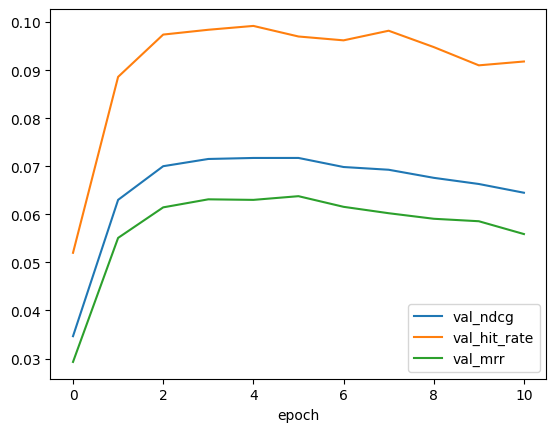

In [63]:
history.drop(columns=['step']).plot(x="epoch")

# 5 Evaluation

In [57]:
test_predict_dataset = CausalLMPredictionDataset(validation_full, max_length=MAX_LENGTH)

test_predict_loader = DataLoader(
    test_predict_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=PaddingCollateFn())

preds_test = trainer.predict(model=seqrec_module, dataloaders=test_predict_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [58]:
preds_test[0]

{'preds': array([[ 3065, 41609, 18325, 34404, 34644,  1766, 29109, 43678, 23342,
         12291],
        [ 8119, 38313, 16478, 14267, 45846, 26204, 22934, 15703, 50327,
         23342],
        [45442, 49990, 13793, 25676, 29834, 50878, 28010,  1458, 38132,
         36280],
        [ 3265, 43596, 27831, 28237, 47456,  6359, 22332, 34938, 41413,
         34533],
        [33424, 19720, 45329, 12928,  6963, 26135, 26385,  1469, 15476,
         38113],
        [  637, 43776, 36735, 31192, 11651, 33909, 42157, 48347, 43247,
         43421],
        [17350, 25061, 17616, 50219,  4843,  4531, 29659, 38274, 28108,
         46248],
        [19385,  8881, 14267, 28237, 15263, 46282, 26204, 50597, 39972,
         40102],
        [16818, 40121,  8656,  7324, 19216, 14488,  8331, 45498, 43918,
         33527],
        [26972, 26941, 17070,  6027, 10034, 36103, 49992, 41160, 42847,
         39912],
        [17922, 11709, 46032, 21160,  7324, 21159, 41702, 15718, 21758,
         12849],
        [ 87

In [59]:
def preds2recs(preds, item_mapping=None):

    user_ids = np.hstack([pred['user_ids'] for pred in preds])
    scores = np.vstack([pred['scores'] for pred in preds])
    preds = np.vstack([pred['preds'] for pred in preds])

    user_ids = np.repeat(user_ids[:, None], repeats=scores.shape[1], axis=1)

    recs = pd.DataFrame({'user_id': user_ids.flatten(),
                         'item_id': preds.flatten(),
                         'prediction': scores.flatten()})

    if item_mapping is not None:
        recs.item_id = recs.item_id.map(item_mapping)

    return recs


In [60]:
recs_test = preds2recs(preds_test)
print(recs_test.shape)
recs_test.head()

(338750, 3)


,user_id,item_id,prediction
0,0,3065,7.798016
1,0,41609,7.649602
2,0,18325,7.075155
3,0,34404,6.863909
4,0,34644,6.819614


### Prediction example

In [64]:
u_features_filtered[u_features_filtered['user_id'] == 4]

,user_id,age,sex
19,4,18_24,0.0


### Full user history

In [70]:
train[train['user_id'] == 4].merge(i_features_filtered, on="item_id").sort_values("start_date")

,user_id,item_id,start_date,time_idx,time_idx_reversed,title,genres,authors,year
0,4,3793,2018-05-01,0,52,Выстрел в сердце,Современная русская литература,Герман Садулаев,2017
1,4,5097,2018-05-22,1,51,Спектр,"Социальная фантастика,Космическая фантастика,Н...",Сергей Лукьяненко,2001-02
2,4,36082,2018-12-05,2,50,История Бледной Моли,"Героическое фэнтези,Любовное фэнтези",Настя Любимка,2017
3,4,11491,2019-03-30,3,49,Честь Белого Волка,Юмористическое фэнтези,Андрей Белянин,2018
4,4,24286,2019-04-15,4,48,Свирепый ландграф,Юмористическое фэнтези,Андрей Белянин,1998
5,4,5004,2019-05-28,5,47,Век святого Скиминока,"Героическое фэнтези,Юмористическое фэнтези",Андрей Белянин,1998
6,4,11448,2019-07-23,6,46,Страж,"Героическое фэнтези,Книги про волшебников",Алексей Пехов,2010
7,4,33648,2019-07-24,7,45,Аутодафе,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2011
8,4,19374,2019-07-29,8,44,Золотые костры,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2012
9,4,6225,2019-08-01,9,43,Проклятый горн,"Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2014


In [65]:
recs_test[recs_test['user_id'] == 4].merge(i_features_filtered, on="item_id")

,user_id,item_id,prediction,title,genres,authors,year
0,4,33424,7.045271,Некрасавица и чудовище,"Книги про волшебников,Любовное фэнтези,Магичес...",Анна Бруша,2019
1,4,19720,6.852182,Танцующая среди ветров. Книга 1. Дружба,"Героическое фэнтези,Любовное фэнтези,Фэнтези п...",Таша Танари,2017
2,4,45329,6.666983,Академия Стихий. Танец Огня,"Попаданцы,Книги про волшебников,Любовное фэнтези","Наталья Жильцова,Анна Гаврилова",2014
3,4,12928,6.561487,Тринадцатый странник,"Эротическое фэнтези,Любовное фэнтези",Марина Суржевская,2016
4,4,6963,6.550079,Право первой ночи,"Любовное фэнтези,Русское фэнтези,Юмористическо...",Елена Звездная,2019
5,4,26135,6.399810,Мой любимый зверь,"Эротическое фэнтези,Остросюжетные любовные ром...",Матильда Старр,2019
6,4,26385,6.373020,Глория. Три знака смерти,"Детективное фэнтези,Книги про волшебников",Наталья Жильцова,2019
7,4,1469,6.263725,Варвара-краса и Тёмный властелин,"Попаданцы,Любовное фэнтези,Юмористическое фэнтези",Милена Завойчинская,2015
8,4,15476,6.192740,Королевская кровь. Горький пепел,"Героическое фэнтези,Любовное фэнтези",Ирина Котова,2019
9,4,38113,6.179773,Махинация,"Любовно-фантастические романы,Космическая фант...",Елена Звездная,2019


### Same history as in the base notebook

In [78]:
test_predict_dataset_4 = CausalLMPredictionDataset(validation_full[(validation_full['user_id'] == 4) & (validation_full['start_date'] <= "2019-08-28")], max_length=MAX_LENGTH)

test_predict_loader_4 = DataLoader(
    test_predict_dataset_4, batch_size=TEST_BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=PaddingCollateFn())

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [79]:
preds_test_4 = trainer.predict(model=seqrec_module, dataloaders=test_predict_loader_4)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [80]:
preds_test_4[0]

{'preds': array([[16645,  8651, 42237, 23326, 10865, 47220,   909, 37850, 45095,
         28071]]),
 'scores': array([[8.207222 , 7.9531527, 7.795918 , 7.789202 , 7.429237 , 7.1485004,
         7.0501533, 7.017529 , 6.990996 , 6.891478 ]], dtype=float32),
 'user_ids': array([4])}

In [83]:
preds2recs(preds_test_4).merge(i_features_filtered, on="item_id")

,user_id,item_id,prediction,title,genres,authors,year
0,4,16645,8.207222,Заклинатели,"Героическое фэнтези,Боевое фэнтези,Книги про в...","Алексей Пехов,Наталья Турчанинова,Елена Бычкова",2011
1,4,8651,7.953153,Ветер и искры (сборник),"Героическое фэнтези,Боевое фэнтези,Книги про в...",Алексей Пехов,2005-2008
2,4,42237,7.795918,Тень ингениума,"Стимпанк,Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2018
3,4,23326,7.789202,Созерцатель,"Стимпанк,Героическое фэнтези,Боевое фэнтези",Алексей Пехов,2016
4,4,10865,7.429237,Ловушка для духа,"Героическое фэнтези,Боевое фэнтези,Книги про в...","Алексей Пехов,Наталья Турчанинова,Елена Бычкова",2016
5,4,47220,7.148500,Мастер снов,Городское фэнтези,"Алексей Пехов,Наталья Турчанинова,Елена Бычкова",2014
6,4,909,7.050153,Искатели ветра,"Героическое фэнтези,Боевое фэнтези,Книги про в...",Алексей Пехов,2005
7,4,37850,7.017529,Приговор некроманту,"Попаданцы,Боевое фэнтези",Владислав Жеребьёв,2019
8,4,45095,6.990996,Создатель кошмаров,Городское фэнтези,"Алексей Пехов,Наталья Турчанинова,Елена Бычкова",2015
9,4,28071,6.891478,Пересмешник,"Детективное фэнтези,Городское фэнтези,Книги пр...",Алексей Пехов,2009
